In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
top_dir = 'images'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. images\train\art_nouveau
1. images\train\baroque
2. images\train\expressionism
3. images\train\impressionism
4. images\train\post_impressionism
5. images\train\realism
6. images\train\renaissance
7. images\train\romanticism
8. images\train\surrealism
9. images\train\ukiyo_e

Train directories containing AI-generated images:
0. images\train\AI_LD_art_nouveau
1. images\train\AI_LD_baroque
2. images\train\AI_LD_expressionism
3. images\train\AI_LD_impressionism
4. images\train\AI_LD_post_impressionism
5. images\train\AI_LD_realism
6. images\train\AI_LD_renaissance
7. images\train\AI_LD_romanticism
8. images\train\AI_LD_surrealism
9. images\train\AI_LD_ukiyo-e
10. images\train\AI_SD_art_nouveau
11. images\train\AI_SD_baroque
12. images\train\AI_SD_expressionism
13. images\train\AI_SD_impressionism
14. images\train\AI_SD_post_impressionism
15. images\train\AI_SD_realism
16. images\train\AI_SD_renaissance
17. images\train\AI_SD_romanticism
1

In [3]:
test_dir = os.path.join(top_dir, 'test')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. images\test\art_nouveau
1. images\test\baroque
2. images\test\expressionism
3. images\test\impressionism
4. images\test\post_impressionism
5. images\test\realism
6. images\test\renaissance
7. images\test\romanticism
8. images\test\surrealism
9. images\test\ukiyo_e

Test directories containing AI-generated images:
0. images\test\AI_LD_art_nouveau
1. images\test\AI_LD_baroque
2. images\test\AI_LD_expressionism
3. images\test\AI_LD_impressionism
4. images\test\AI_LD_post_impressionism
5. images\test\AI_LD_realism
6. images\test\AI_LD_renaissance
7. images\test\AI_LD_romanticism
8. images\test\AI_LD_surrealism
9. images\test\AI_LD_ukiyo-e
10. images\test\AI_SD_art_nouveau
11. images\test\AI_SD_baroque
12. images\test\AI_SD_expressionism
13. images\test\AI_SD_impressionism
14. images\test\AI_SD_post_impressionism
15. images\test\AI_SD_realism
16. images\test\AI_SD_renaissance
17. images\test\AI_SD_romanticism
18. images\test\AI_SD_surrealis

In [4]:
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

In [5]:
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

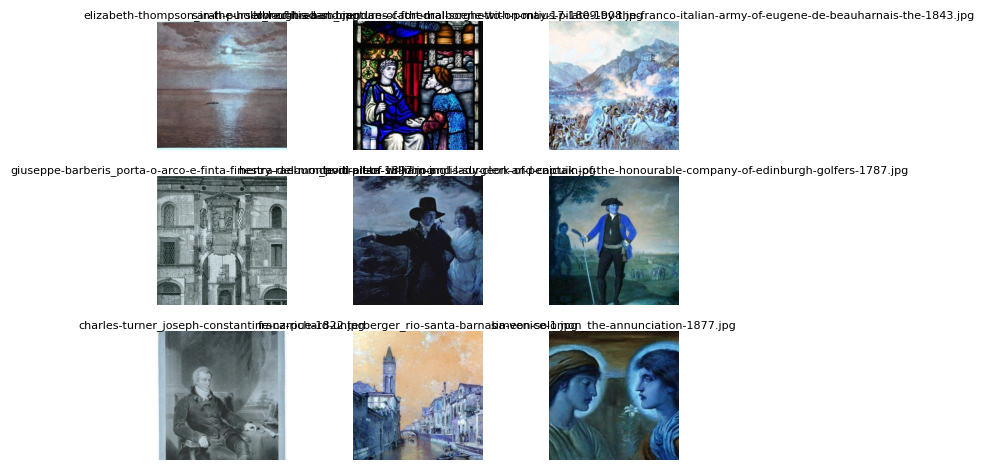

In [6]:
real_im = plot_im(directory=train_human[7], k=9)  
plt.show()

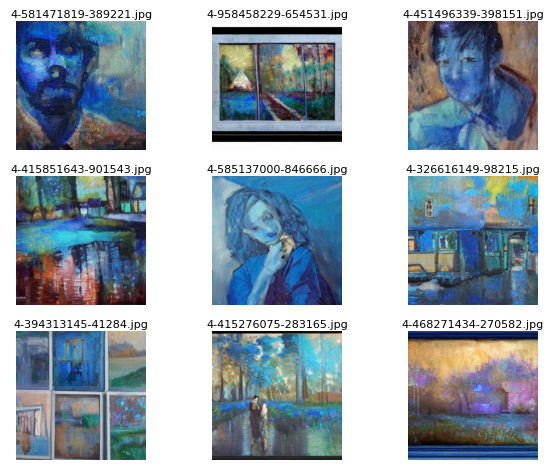

In [7]:
ai_im = plot_im(directory=train_ai[4], k=9)  
plt.show()

In [8]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [9]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  images\train\art_nouveau\a-y-jackson_algoma-in...  human
1  images\train\art_nouveau\a-y-jackson_first-sno...  human
2  images\train\art_nouveau\a-y-jackson_frozen-la...  human
3  images\train\art_nouveau\a-y-jackson_grey-day-...  human
4  images\train\art_nouveau\a-y-jackson_hills-at-...  human


In [10]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


In [11]:
# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = 55015

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

In [12]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  images\train\art_nouveau\a-y-jackson_algoma-in...  human
1  images\train\art_nouveau\a-y-jackson_first-sno...  human
2  images\train\art_nouveau\a-y-jackson_frozen-la...  human
3  images\train\art_nouveau\a-y-jackson_grey-day-...  human
4  images\train\art_nouveau\a-y-jackson_hills-at-...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


In [13]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [14]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  images\test\art_nouveau\a-y-jackson_a-copse-ev...  human
1  images\test\art_nouveau\a-y-jackson_skeena-cro...  human
2  images\test\art_nouveau\a-y-jackson_the-beothi...  human
3  images\test\art_nouveau\achille-beltrame_a-goo...  human
4  images\test\art_nouveau\achille-beltrame_a-mob...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


In [15]:
training_generator = ImageDataGenerator(rescale=1./255,   # to normalize pixel value
                                       # rotation_range=7, # it will apply rotations to the image
                                       # horizontal_flip=True, # it will flip image horizontally
                                       # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',  
    shuffle=True
)

Found 100000 validated image filenames belonging to 2 classes.


In [16]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

In [17]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_dataframe(  dataframe=test_data,
                                                    x_col='filepath',  # Column containing file paths
                                                    y_col='label',     # Column containing labels
                                                    target_size = (32, 32),
                                                    batch_size = 1,    # 1 image at a time to evaluate the NN
                                                    class_mode = 'categorical',
                                                    shuffle = False)   # to associate the prediction with expected output

test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

In [18]:
network = Sequential()
network.add(Conv2D(filters = 64, kernel_size = 3, input_shape = (32,32,3), activation='relu'))
network.add(MaxPooling2D())
network.add(Conv2D(filters = 64, kernel_size = 3, activation='relu'))
network.add(MaxPooling2D())
network.add(Flatten())
network.add(Dense(units = 64, activation='relu'))
network.add(Dense(units = 2, activation='softmax'))

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
network.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,370 (728.01 KB)

 Trainable params: 186,370 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from keras.callbacks import ModelCheckpoint

# Define the file path where the model will be saved
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
import time

# Initial epoch count
epochs = 10

# Initialize total training time
total_training_time = 0

# Loop to allow user to continue training
while True:
    # Record start time
    start_time = time.time()
    
    # Fit the model for the specified number of epochs
    history = network.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint])
    
    # Calculate training time for the current batch of epochs
    training_time = time.time() - start_time
    total_training_time += training_time
    
    # Print total training time
    print("Total training time so far: {:.2f} seconds".format(total_training_time))
    
    # Prompt the user to continue training or stop
    user_input = input("Enter 'c' to continue training for more epochs, or any other key to stop: ")
    
    # If user input is not 'c', break out of the loop
    if user_input != 'c':
        break
    
    # Ask the user for the number of additional epochs
    additional_epochs = int(input("Enter the number of additional epochs you want to train for: "))
    
    # Update the epoch count for the next training loop
    epochs += additional_epochs

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7934 - loss: 0.4165
Epoch 1: val_accuracy improved from -inf to 0.88883, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1080s 688ms/step - accuracy: 0.7934 - loss: 0.4164 - val_accuracy: 0.8888 - val_loss: 0.2620
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8947 - loss: 0.2510
Epoch 2: val_accuracy improved from 0.88883 to 0.91703, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 898s 574ms/step - accuracy: 0.8947 - loss: 0.2510 - val_accuracy: 0.9170 - val_loss: 0.2118
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9145 - loss: 0.2068
Epoch 3: val_accuracy did not improve from 0.91703
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 835s 534ms/step - accuracy: 0.9145 - loss: 0.2068 - val_accuracy: 0.9132 - val_loss: 0.2083
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9248 - loss: 0.1849
Epoch 4: val_accuracy improved from 0.91703 

In [22]:
print("Train Dataset Shape:", train_dataset[0][0].shape)
print("Validation Dataset Shape:", test_dataset[0][0].shape)


Train Dataset Shape: (64, 32, 32, 3)
Validation Dataset Shape: (1, 32, 32, 3)


In [70]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json) #save network json

from keras.models import save_model
network_saved = save_model(network, '/kaggle/working/weights.hdf5') 

In [73]:
img = ef(image)

if img is None:
    print("Error: Image preprocessing function `ef(image)` returned None!")
else:
    print("Image processed successfully:", img.shape)


AttributeError: 'str' object has no attribute 'load_img'

In [74]:
print(train_dataset[0][0].shape)  # Input images
print(train_dataset[0][1].shape)  # Labels


(64, 32, 32, 3)
(64, 2)


In [25]:
predictions = network.predict(test_dataset)
predictions

30000/30000 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step


array([[3.3815089e-09, 1.0000000e+00],
       [4.0893871e-01, 5.9106123e-01],
       [1.9493719e-07, 9.9999976e-01],
       ...,
       [1.0000000e+00, 3.7336492e-16],
       [9.8818398e-01, 1.1816044e-02],
       [9.9999654e-01, 3.4474731e-06]], dtype=float32)

In [75]:
test_dataset.class_indices

{'AI': 0, 'human': 1}

In [77]:
predictions = np.argmax(predictions, axis = 1)
predictions

AxisError: axis 3 is out of bounds for array of dimension 1

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     20000
           1       0.87      0.92      0.90     10000

    accuracy                           0.93     30000
   macro avg       0.92      0.93      0.92     30000
weighted avg       0.93      0.93      0.93     30000



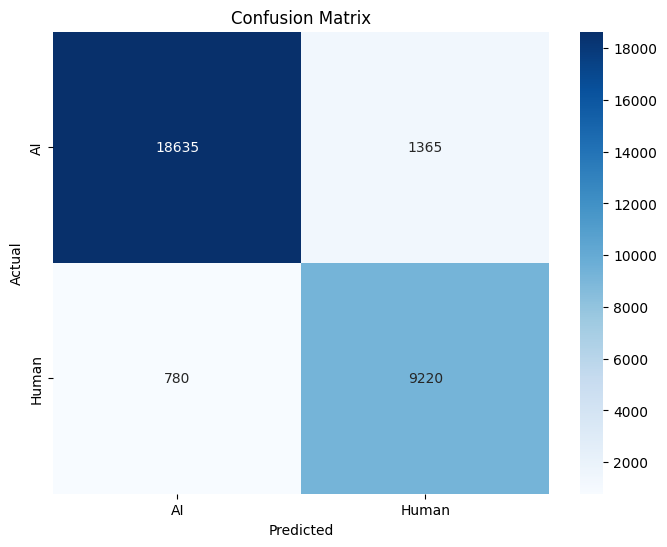

In [50]:
#import seaborn as sns 
#from sklearn.metrics import confusion_matrix, classification_report
#cm = confusion_matrix(test_dataset.classes, predictions)
#sns.heatmap(cm, annot=True)
#print(classification_report(test_dataset.classes, predictions))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix and classification report
cm = confusion_matrix(test_dataset.classes, predictions)
report = classification_report(test_dataset.classes, predictions)

# Define custom labels for the axes
labels = ['AI','Human']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Add labels to the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print classification report
print(report)

In [29]:
label=['AI','Human']

In [90]:
import os

image_path = r"C:\Users\lenovo\Desktop\coding\AI_Art_Detector\images\test\AI_LD_expressionism\2-10165305-28388.jpg"

if os.path.exists(image_path):
    print("✅ Image file found!")
else:
    print("❌ Image file NOT found. Check the path!")


✅ Image file found!


In [91]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def ef(image):
    img = load_img(image, color_mode="rgb", target_size=(32, 32))
    feature = img_to_array(img)
    feature = feature.reshape(1, 32, 32, 3)
    return feature / 255.0

In [94]:
image=r"C:\Users\lenovo\Desktop\coding\AI_Art_Detector\images\test\AI_LD_post_impressionism\4-1449948-211874.jpg"
print("Original image is AI")
img=ef(image)
pred=network_saved.predict(img)
pred_label=label[pred.argmax()]
print("Model prediction is:",pred_label)

Original image is AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Model prediction is: AI


In [95]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model


# Assuming 'ef' is your preprocessing function
def ef(image_path):
    img = image.load_img(image_path, target_size=(32, 32))  # Resize image to match model input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Path to the image you want to classify
image_path = r"C:\Users\lenovo\Desktop\coding\AI_Art_Detector\images\test\AI_LD_baroque\1-1900923-254510.jpg"


# Preprocess the image
img = ef(image_path)

# Check if the model is loaded
if network_saved:
    # Make a prediction
    pred = network_saved.predict(img)

    # Get the class label of the predicted class
    labels = ['AI', 'Human']  # Modify this based on your dataset classes
    pred_label = labels[pred.argmax()]  # Get the label of the predicted class

    # Output the result
    print("Model prediction is:", pred_label)
else:
    print("Model is not loaded correctly. Please check the model file path.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Model prediction is: AI


In [96]:
from tensorflow.keras.models import load_model

# Load the model (Make sure the path is correct!)
model_path = r"C:\Users\lenovo\Desktop\coding\AI_Art_Detector\best_model.keras"

try:
    network_saved = load_model(model_path)
    print("✅ Model loaded successfully!")
except Exception as e:
    print("❌ Error loading model:", e)
    network_saved = None


✅ Model loaded successfully!


In [97]:
import os

model_path = r"C:\Users\lenovo\Desktop\coding\AI_Art_Detector\best_model.keras"

if os.path.exists(model_path):
    print("✅ Model file found:", model_path)
else:
    print("❌ Model file NOT found. Check the path!")


✅ Model file found: C:\Users\lenovo\Desktop\coding\AI_Art_Detector\best_model.keras


In [98]:
import matplotlib.pyplot as plt

In [99]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

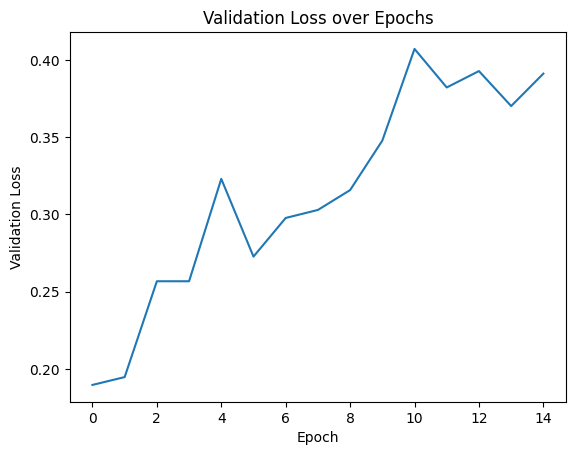

In [100]:
plt.plot(history.history['val_loss']);
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()